In [1]:
import os

os.environ["AZURE_OPENAI_API_KEY"] = os.getenv('Key_AzureOpenAI')
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv('Endpoint_AzureOpenAI')

In [2]:
from autogen_agentchat.agents import CodingAssistantAgent, ToolUseAssistantAgent
from autogen_agentchat.task import TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_core.components.tools import FunctionTool

/Users/michael/PycharmProjects/2024BarclaysHackathonNew/.venv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_usage" in BaseMessage has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/michael/PycharmProjects/2024BarclaysHackathonNew/.venv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_usage" in TextMessage has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/michael/PycharmProjects/2024BarclaysHackathonNew/.venv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_usage" in MultiModalMessage has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  w

In [3]:
# testing 
from autogen_core.components.models import AzureOpenAIChatCompletionClient, UserMessage

azure_client = AzureOpenAIChatCompletionClient(
    model="gpt-4o",
    api_version="2024-02-01",
    model_capabilities={
        "vision":True,
        "function_calling":True,
        "json_output":True,
    }
)

/var/folders/wp/6gm0gp7n5653wzt3d3527vsw0000gn/T/ipykernel_25690/3925474547.py:2: FutureWarning: AzureOpenAIChatCompletionClient moved to autogen_ext. Please import it from autogen_ext.models.AzureOpenAIChatCompletionClient.
  from autogen_core.components.models import AzureOpenAIChatCompletionClient, UserMessage


In [4]:
model_client_result = await azure_client.create(
    messages=[
        UserMessage(content="What is the capital of France?", source="user"),
    ]
)
print(model_client_result)  # "Paris"

CreateResult(finish_reason='stop', content='The capital of France is Paris.', usage=RequestUsage(prompt_tokens=15, completion_tokens=7), cached=False, logprobs=None)


/var/folders/wp/6gm0gp7n5653wzt3d3527vsw0000gn/T/ipykernel_25690/3684532785.py:1: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-05-13. Model mapping may be incorrect.
  model_client_result = await azure_client.create(


Plot saved as coding/AAL_stockprice.png


In [5]:
import os
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from pytz import timezone  # type: ignore

def stock_news(ticker: str) -> list:
    """
    Get the most recent news of a stock or an instrument from Yahoo Finance

    Args:
    ticker (str): the stock ticker to be given to yfinance
    """
    stock = yf.Ticker(ticker)
    list_news = stock.news[0:2]
    return list_news


def analyze_stock(ticker: str) -> dict:  # type: ignore[type-arg]
    stock = yf.Ticker(ticker)

    # Get historical data (1 year of data to ensure we have enough for 200-day MA)
    end_date = datetime.now(timezone("UTC"))
    start_date = end_date - timedelta(days=365)
    hist = stock.history(start=start_date, end=end_date)

    # Ensure we have data
    if hist.empty:
        return {"error": "No historical data available for the specified ticker."}

    # Compute basic statistics and additional metrics
    current_price = stock.info.get("currentPrice", hist["Close"].iloc[-1])
    year_high = stock.info.get("fiftyTwoWeekHigh", hist["High"].max())
    year_low = stock.info.get("fiftyTwoWeekLow", hist["Low"].min())

    # Calculate 50-day and 200-day moving averages
    ma_50 = hist["Close"].rolling(window=50).mean().iloc[-1]
    ma_200 = hist["Close"].rolling(window=200).mean().iloc[-1]

    # Calculate YTD price change and percent change
    ytd_start = datetime(end_date.year, 1, 1, tzinfo=timezone("UTC"))
    ytd_data = hist.loc[ytd_start:]  # type: ignore[misc]
    if not ytd_data.empty:
        price_change = ytd_data["Close"].iloc[-1] - ytd_data["Close"].iloc[0]
        percent_change = (price_change / ytd_data["Close"].iloc[0]) * 100
    else:
        price_change = percent_change = np.nan

    # Determine trend
    if pd.notna(ma_50) and pd.notna(ma_200):
        if ma_50 > ma_200:
            trend = "Upward"
        elif ma_50 < ma_200:
            trend = "Downward"
        else:
            trend = "Neutral"
    else:
        trend = "Insufficient data for trend analysis"

    # Calculate volatility (standard deviation of daily returns)
    daily_returns = hist["Close"].pct_change().dropna()
    volatility = daily_returns.std() * np.sqrt(252)  # Annualized volatility

    # Create result dictionary
    result = {
        "ticker": ticker,
        "current_price": current_price,
        "52_week_high": year_high,
        "52_week_low": year_low,
        "50_day_ma": ma_50,
        "200_day_ma": ma_200,
        "ytd_price_change": price_change,
        "ytd_percent_change": percent_change,
        "trend": trend,
        "volatility": volatility,
    }

    # Convert numpy types to Python native types for better JSON serialization
    for key, value in result.items():
        if isinstance(value, np.generic):
            result[key] = value.item()

    # Generate plot
    plt.figure(figsize=(12, 6))
    plt.plot(hist.index, hist["Close"], label="Close Price")
    plt.plot(hist.index, hist["Close"].rolling(window=50).mean(), label="50-day MA")
    plt.plot(hist.index, hist["Close"].rolling(window=200).mean(), label="200-day MA")
    plt.title(f"{ticker} Stock Price (Past Year)")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)

    # Save plot to file
    os.makedirs("coding", exist_ok=True)
    plot_file_path = f"coding/{ticker}_stockprice.png"
    plt.savefig(plot_file_path)
    print(f"Plot saved as {plot_file_path}")
    result["plot_file_path"] = plot_file_path

    return result

Plot saved as coding/AAPL_stockprice.png


{'ticker': 'AAPL',
 'current_price': 222.91,
 '52_week_high': 237.49,
 '52_week_low': 164.08,
 '50_day_ma': 227.1338003540039,
 '200_day_ma': 201.88410690307617,
 'ytd_price_change': 37.97178649902344,
 'ytd_percent_change': 20.532146941558537,
 'trend': 'Upward',
 'volatility': 0.22622808312989715,
 'plot_file_path': 'coding/AAPL_stockprice.png'}

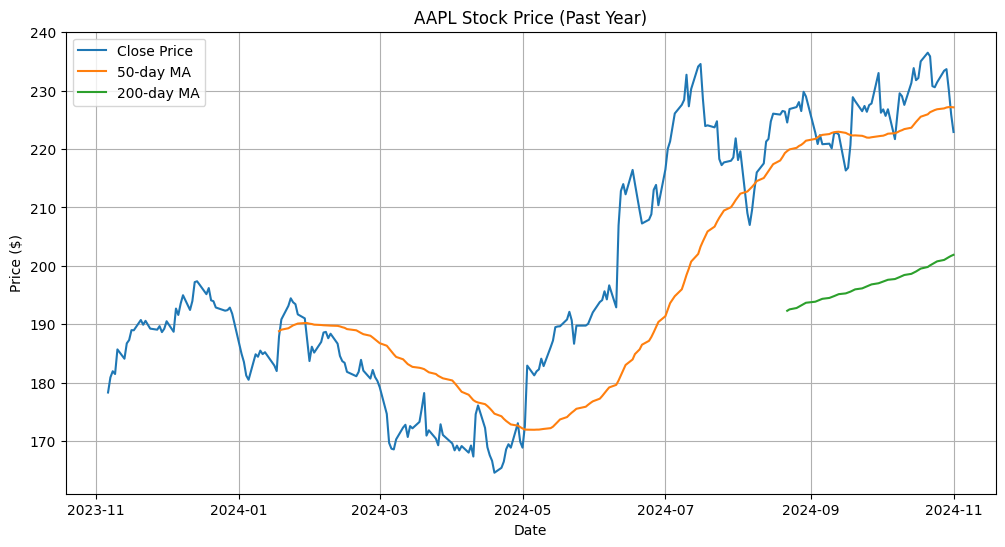

In [51]:
analyze_stock('AAPL')

In [7]:
stock_analysis_tool = FunctionTool(analyze_stock, description="Analyze stock data and generate a plot")
google_search_tool = FunctionTool(
    stock_news, description="Search Google for information, returns results with a snippet and body content"
)

In [16]:
search_agent = ToolUseAssistantAgent(
    name="News_Analyzs_Agent",
    model_client=azure_client,
    registered_tools=[google_search_tool],
    description="Get the most recent news of a stock or an instrument from Yahoo Finance",
    system_message="You are a helpful AI assistant. Solve tasks using your tools.",
)

stock_analysis_agent = ToolUseAssistantAgent(
    name="Stock_Analysis_Agent",
    model_client=azure_client,
    registered_tools=[stock_analysis_tool],
    description="Analyze stock data and generate a plot",
    system_message="You are a helpful AI assistant. Solve tasks using your tools.",
)

report_agent = CodingAssistantAgent(
    name="Report_Agent",
    model_client=azure_client,
    description="Generate a report based on the search and stock analysis results, which is easy to read in python environment",
    system_message="You are a helpful assistant that can generate a comprehensive report on a given topic based on search and stock analysis. When you done with generating the report, reply with TERMINATE.",
)

termination = TextMentionTermination("TERMINATE")
team = RoundRobinGroupChat([search_agent, stock_analysis_agent, report_agent], termination_condition=termination)

/var/folders/wp/6gm0gp7n5653wzt3d3527vsw0000gn/T/ipykernel_25690/4098346914.py:1: DeprecationWarning: ToolUseAssistantAgent is deprecated. Use AssistantAgent instead.
  search_agent = ToolUseAssistantAgent(
/var/folders/wp/6gm0gp7n5653wzt3d3527vsw0000gn/T/ipykernel_25690/4098346914.py:9: DeprecationWarning: ToolUseAssistantAgent is deprecated. Use AssistantAgent instead.
  stock_analysis_agent = ToolUseAssistantAgent(
/var/folders/wp/6gm0gp7n5653wzt3d3527vsw0000gn/T/ipykernel_25690/4098346914.py:17: DeprecationWarning: CodingAssistantAgent is deprecated. Use AssistantAgent instead.
  report_agent = CodingAssistantAgent(


/Users/michael/PycharmProjects/2024BarclaysHackathonNew/.venv/lib/python3.10/site-packages/autogen_agentchat/agents/_assistant_agent.py:299: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-05-13. Model mapping may be incorrect.
  result = await self._model_client.create(
/Users/michael/PycharmProjects/2024BarclaysHackathonNew/.venv/lib/python3.10/site-packages/autogen_agentchat/agents/_assistant_agent.py:258: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-05-13. Model mapping may be incorrect.
  result = await self._model_client.create(


TaskResult(messages=[TextMessage(source='user', model_usage=None, content='Write a financial report on American airlines'), ToolCallMessage(source='News_Analyzs_Agent', model_usage=RequestUsage(prompt_tokens=79, completion_tokens=31), content=[FunctionCall(id='call_lC52hXEFE2ey7XBcs4OPXVZ5', arguments='{"ticker": "AAL"}', name='stock_news')]), ToolCallResultMessage(source='News_Analyzs_Agent', model_usage=None, content=[FunctionExecutionResult(content="[{'uuid': '7cad5834-fed2-3f52-956f-05775cb7f7c7', 'title': 'New DOT rule requires airlines to refund travelers for flight delays', 'publisher': 'Yahoo Finance Video', 'link': 'https://finance.yahoo.com/video/dot-rule-requires-airlines-refund-171500384.html', 'providerPublishTime': 1730481300, 'type': 'VIDEO', 'thumbnail': {'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/ZtqJ.Tt7qRgVYusd9Hya2A--~B/aD00NTA0O3c9ODAwMDthcHBpZD15dGFjaHlvbg--/https://s.yimg.com/os/creatr-uploaded-images/2024-11/2d647430-986d-11ef-8df6-90bebb417170',

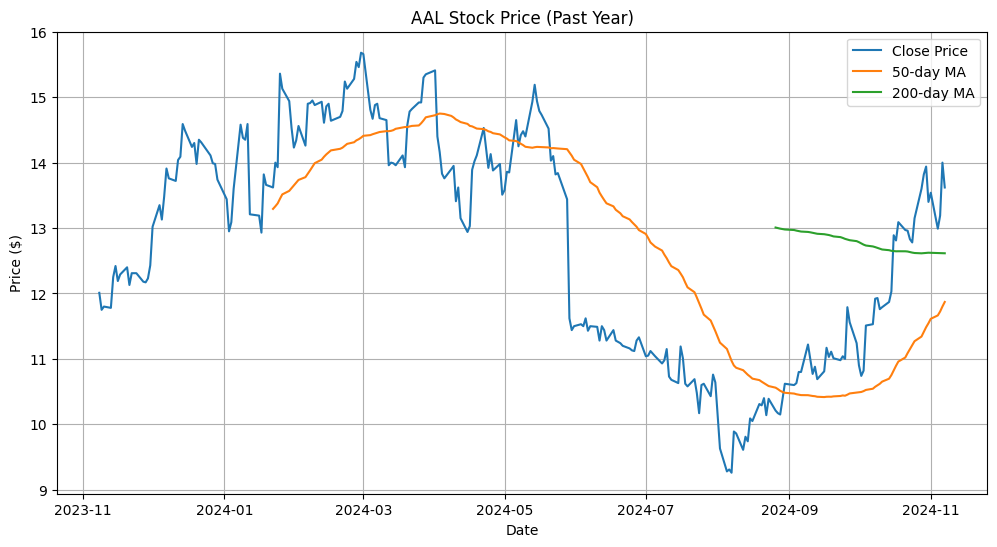

In [17]:
result = await team.run("Write a financial report on American airlines")
print(result)

In [18]:
for i in range(len(result.messages)):
    print(result.messages[i])
    print('________________________')

source='user' model_usage=None content='Write a financial report on American airlines'
________________________
source='News_Analyzs_Agent' model_usage=RequestUsage(prompt_tokens=79, completion_tokens=31) content=[FunctionCall(id='call_lC52hXEFE2ey7XBcs4OPXVZ5', arguments='{"ticker": "AAL"}', name='stock_news')]
________________________
source='News_Analyzs_Agent' model_usage=None content=[FunctionExecutionResult(content="[{'uuid': '7cad5834-fed2-3f52-956f-05775cb7f7c7', 'title': 'New DOT rule requires airlines to refund travelers for flight delays', 'publisher': 'Yahoo Finance Video', 'link': 'https://finance.yahoo.com/video/dot-rule-requires-airlines-refund-171500384.html', 'providerPublishTime': 1730481300, 'type': 'VIDEO', 'thumbnail': {'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/ZtqJ.Tt7qRgVYusd9Hya2A--~B/aD00NTA0O3c9ODAwMDthcHBpZD15dGFjaHlvbg--/https://s.yimg.com/os/creatr-uploaded-images/2024-11/2d647430-986d-11ef-8df6-90bebb417170', 'width': 8000, 'height': 4504,

In [19]:
print(result.messages[-1].content)

### Financial Report on American Airlines (Ticker: AAL)

#### Current News and Developments

1. **DOT Rule on Refunds for Flight Delays**
   - **Source**: Yahoo Finance Video
   - **Published**: Recently
   - **Summary**: A new rule from the U.S. Department of Transportation (DOT) mandates airlines, including American Airlines, to refund travelers for flight delays. This regulation is expected to have significant financial implications for airlines, potentially increasing their operational costs and impacting their profit margins.

2. **Expansion in Italy**
   - **Source**: MT Newswires via Yahoo Finance
   - **Published**: Recently
   - **Summary**: American Airlines announced plans to offer more flights to Italy in 2025. This strategic expansion aims to capture additional market share in the lucrative European travel market, which could boost their international revenue streams.

#### Stock Analysis

- **Current Price**: $13.62
- **52-Week High**: $16.15
- **52-Week Low**: $9.07
- **

In [85]:
stock_news("AAL")

[{'uuid': '7cad5834-fed2-3f52-956f-05775cb7f7c7',
  'title': 'New DOT rule requires airlines to refund travelers for flight delays',
  'publisher': 'Yahoo Finance Video',
  'link': 'https://finance.yahoo.com/video/dot-rule-requires-airlines-refund-171500384.html',
  'providerPublishTime': 1730481300,
  'type': 'VIDEO',
  'thumbnail': {'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/ZtqJ.Tt7qRgVYusd9Hya2A--~B/aD00NTA0O3c9ODAwMDthcHBpZD15dGFjaHlvbg--/https://s.yimg.com/os/creatr-uploaded-images/2024-11/2d647430-986d-11ef-8df6-90bebb417170',
     'width': 8000,
     'height': 4504,
     'tag': 'original'},
    {'url': 'https://s.yimg.com/uu/api/res/1.2/AudTBTotFlr.W.YKLRIqyw--~B/Zmk9ZmlsbDtoPTE0MDtweW9mZj0wO3c9MTQwO2FwcGlkPXl0YWNoeW9u/https://s.yimg.com/os/creatr-uploaded-images/2024-11/2d647430-986d-11ef-8df6-90bebb417170',
     'width': 140,
     'height': 140,
     'tag': '140x140'}]},
  'relatedTickers': ['UAL',
   'AAL',
   'SAVE',
   'DAL',
   'ALK',
   'ULCC',
   'JBLU',

In [13]:
termination = TextMentionTermination("TERMINATE")
team = RoundRobinGroupChat([search_agent, report_agent], termination_condition=termination)

In [14]:
result = await team.run("what are the competators for American Airline")
print(result)

TaskResult(messages=[TextMessage(source='user', model_usage=None, content='what are the competators for American Airline'), TextMessage(source='News_Analyzs_Agent', model_usage=RequestUsage(prompt_tokens=956, completion_tokens=268), content='American Airlines operates in a highly competitive airline industry, facing competition from several major carriers. Some of its primary competitors include:\n\n1. **United Airlines (UAL)**: United Airlines is a leading American airline that competes with American Airlines on numerous domestic and international routes.\n\n2. **Delta Air Lines (DAL)**: Delta is one of the largest airlines in the world and a direct competitor to American Airlines, particularly on transatlantic and transcontinental routes.\n\n3. **Southwest Airlines (LUV)**: Known for its low-cost model, Southwest Airlines competes with American Airlines on various domestic routes.\n\n4. **JetBlue Airways (JBLU)**: JetBlue is another significant competitor, especially on domestic rout

In [15]:
for i in range(len(result.messages)):
    print(result.messages[i].content)
    print('________________________')

what are the competators for American Airline
________________________
American Airlines operates in a highly competitive airline industry, facing competition from several major carriers. Some of its primary competitors include:

1. **United Airlines (UAL)**: United Airlines is a leading American airline that competes with American Airlines on numerous domestic and international routes.

2. **Delta Air Lines (DAL)**: Delta is one of the largest airlines in the world and a direct competitor to American Airlines, particularly on transatlantic and transcontinental routes.

3. **Southwest Airlines (LUV)**: Known for its low-cost model, Southwest Airlines competes with American Airlines on various domestic routes.

4. **JetBlue Airways (JBLU)**: JetBlue is another significant competitor, especially on domestic routes and flights to the Caribbean and Latin America.

5. **Alaska Airlines (ALK)**: Alaska Airlines competes with American Airlines on routes to and from the West Coast.

6. **Spiri